In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersControl,
    ThrustersParameters,
    ThrustersAlarms,
)
from input_output.base import Stamped, StampedDf
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
import polars as pl
from simulation.models.fmu_paths import thrusters_path

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=120 - 1)


supply_temperature = StampedDf.stamp(
    pl.DataFrame({
        "time": pl.datetime_range(
            start_time, start_time + duration, interval="1m", time_unit="us", eager=True
        ),
        "value": 90 * [50.0] + 30 * [80.0],
    })
)
fwd_thruster_active = StampedDf.stamp(
    pl.DataFrame({
        "time": pl.datetime_range(
            start_time, start_time + duration, interval="1m", time_unit="us", eager=True
        ),
        "value": 60 * ["True"] + 60 * ["False"],
    })
)
fwd_thruster_heat = StampedDf.stamp(
    pl.DataFrame({
        "time": pl.datetime_range(
            start_time, start_time + duration, interval="1m", time_unit="us", eager=True
        ),
        "value": 60 * [4300.0] + 60 * [0.0],
    })
)


simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=Stamped.stamp(9000.0), active=Stamped.stamp(True)),
    # thrusters_fwd=Thruster(heat_flow=Stamped.stamp(4300.0), active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=fwd_thruster_heat, active=fwd_thruster_active),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(20.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
    thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
)

control = ThrustersControl(
    ThrustersParameters(
        cooling_mix_setpoint=40,
        recovery_thruster_flow=10,
        cooling_thruster_flow=22,
        max_temp=70,
        recovery_mix_setpoint=60,
    )
)
control.to_recovery()

thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with thrusters_model.executor() as executor:
    simulation = Simulator(thrusters_model, executor)
    result = await simulation.run(int(duration.total_seconds()))


[WARNING] Warning: The following was detected at time: 4.686242511022535E-26
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_mixing_return: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.00983)
  Failed condition: thrusterModule.flowJoin_mixing_return.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 2.010123200637635E-23
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_thruster_out: Flow splitRatio is negative and far below 0. But it must be between 0 and 1. (is -3.30264e+15)
  Failed condition: thrusterModule.flowJoin_thruster_out.splitRatio >= -0.001

[WARNING] Warning: The following was detected at time: 1.532796717500692E-10
[WARNING]   Thruster_Module_FMU.thrusterModule.flowJoin_AFT: Flow splitRatio is far above 1. But it must be between 0 and 1. (is 1.001)
  Failed condition: thrusterModule.flowJoin_AFT.splitRatio <= 1.001

[WARNING] Warning: The following was detected at time: 6.535411437471817E-08
[WARNING]   Thru

In [6]:
selected_control_keys = [
    "thrusters_mix_aft__setpoint__ratio",
    "thrusters_mix_fwd__setpoint__ratio",
    "thrusters_shutoff_recovery__setpoint__ratio",
    "thrusters_switch_aft__setpoint__ratio",
    "thrusters_switch_fwd__setpoint__ratio",
    "thrusters_pump_1__dutypoint__ratio",
]

temperature_keys = [
    "thrusters_module_return__temperature__C",
    "thrusters_temperature_aft_mix__temperature__C",
    "thrusters_temperature_fwd_mix__temperature__C",
    "thrusters_temperature_aft_return__temperature__C",
    "thrusters_temperature_fwd_return__temperature__C",
    "thrusters_seawater_return__temperature__C",
    "thrusters_module_supply__temperature__C",
]
flow_keys = [
    #"thrusters_module_return__flow__l_min",
    "thrusters_module_supply__flow__l_min",
    "thrusters_flow_aft__flow__l_min",
    "thrusters_flow_fwd__flow__l_min",
    "thrusters_flow_recovery_aft__flow__l_min",
    "thrusters_flow_recovery_fwd__flow__l_min",
]
valve_keys = [col for col in result.columns if "position_rel" in col]

selected_keys = [selected_control_keys, valve_keys, temperature_keys, flow_keys]

recovery_df = result.filter(pl.col("time") < datetime.fromtimestamp(60 * 60))
modes_df = result.filter(pl.col("time") >= datetime.fromtimestamp(50 * 60))

recovery_frames = [
    recovery_df.select([
        col for col in recovery_df.columns if col in keys or col == "time"
    ])
    .to_pandas()
    .set_index("time")
    for keys in selected_keys
]  # [selected_control_keys, selected_sensor_keys, sensor_temp_keys, sensor_flow_keys, simulation_temp_keys, simulation_flow_keys]]
modes_frames = [
    modes_df.select([col for col in modes_df.columns if col in keys or col == "time"])
    .to_pandas()
    .set_index("time")
    for keys in selected_keys
]  # [selected_control_keys, selected_sensor_keys, sensor_temp_keys, sensor_flow_keys, simulation_temp_keys, simulation_flow_keys]]


def strip_names(df):
    return df.rename(
        columns={col: col.split("__")[0].split("_", 1)[-1] for col in df.columns}
    )

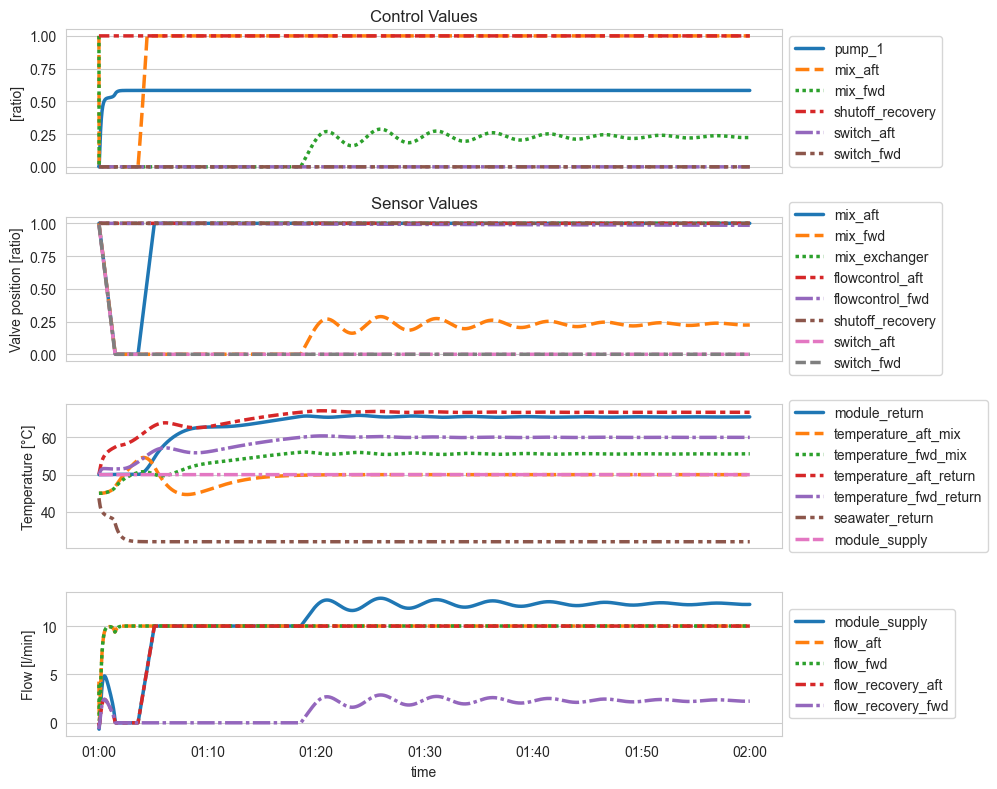

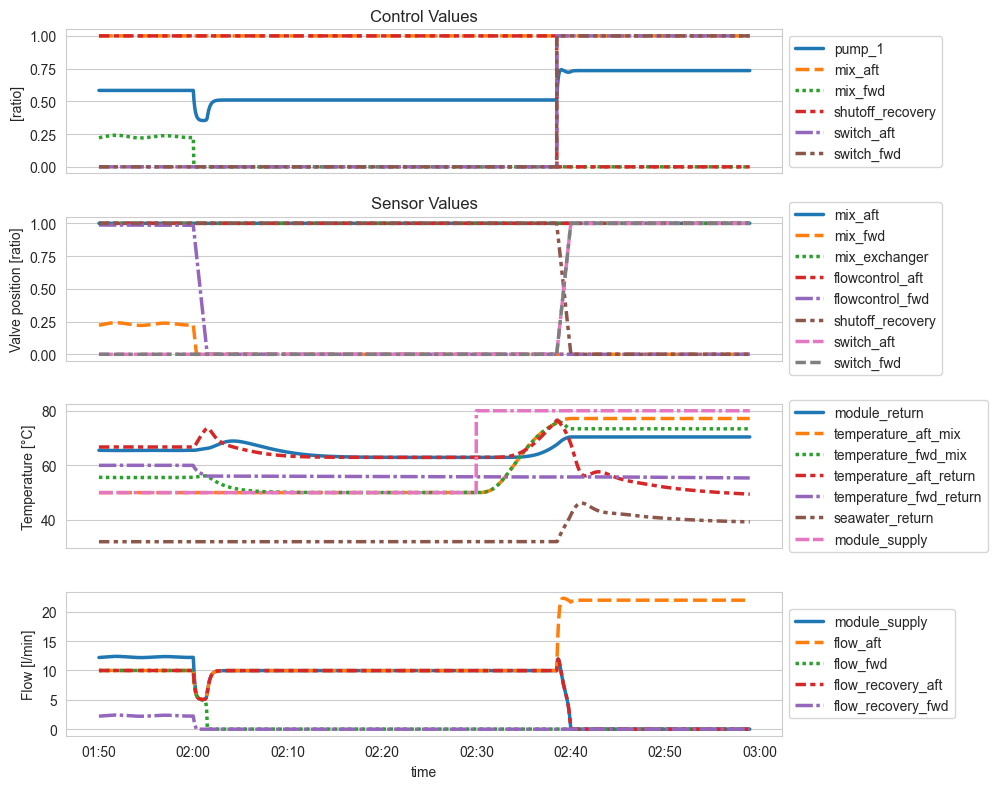

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style("whitegrid")
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"

fig, axes = plt.subplots(
    len(recovery_frames), 1, figsize=(10, len(recovery_frames) * 2), sharex=True
)


for i, df in enumerate([strip_names(df) for df in recovery_frames]):
    sns.lineplot(df, linewidth=2.5, ax=axes[i])
    axes[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

axes[0].set_title("Control Values")
axes[0].set_ylabel("[ratio]")

axes[1].set_title("Sensor Values")
axes[1].set_ylabel("Valve position [ratio]")

axes[2].set_ylabel("Temperature [°C]")

axes[3].set_ylabel("Flow [l/min]")

plt.tight_layout()
plt.savefig("plots/recovery.png", dpi=300, bbox_inches="tight")

fig, axes = plt.subplots(
    len(modes_frames), 1, figsize=(10, len(modes_frames) * 2), sharex=True
)


for i, df in enumerate([strip_names(df) for df in modes_frames]):
    sns.lineplot(df, linewidth=2.5, ax=axes[i])
    axes[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

axes[0].set_title("Control Values")
axes[0].set_ylabel("[ratio]")

axes[1].set_title("Sensor Values")
axes[1].set_ylabel("Valve position [ratio]")

axes[2].set_ylabel("Temperature [°C]")

axes[3].set_ylabel("Flow [l/min]")


plt.tight_layout()
plt.savefig("plots/modes.png", dpi=300, bbox_inches="tight")
